Epoch 1/10
42/42 [==============================] - 14s 192ms/step - loss: 1.0702 - accuracy: 0.7161 - val_loss: 0.4603 - val_accuracy: 0.7918
Epoch 2/10
42/42 [==============================] - 8s 181ms/step - loss: 0.4082 - accuracy: 0.7932 - val_loss: 0.3813 - val_accuracy: 0.8040
Epoch 3/10
42/42 [==============================] - 7s 172ms/step - loss: 0.3867 - accuracy: 0.8047 - val_loss: 0.3831 - val_accuracy: 0.8075
Epoch 4/10
42/42 [==============================] - 7s 161ms/step - loss: 0.3867 - accuracy: 0.8053 - val_loss: 0.3814 - val_accuracy: 0.8099
Epoch 5/10
42/42 [==============================] - 6s 155ms/step - loss: 0.3780 - accuracy: 0.8098 - val_loss: 0.3726 - val_accuracy: 0.8117
Epoch 6/10
42/42 [==============================] - 6s 155ms/step - loss: 0.3776 - accuracy: 0.8095 - val_loss: 0.3872 - val_accuracy: 0.8025
Epoch 7/10
42/42 [==============================] - 6s 154ms/step - loss: 0.3781 - accuracy: 0.8090 - val_loss: 0.3709 - val_accuracy: 0.8114
Epoch

INFO:tensorflow:Assets written to: path_to_save_model/my_unet_model/assets


1/1 [==============================] - 0s 206ms/step


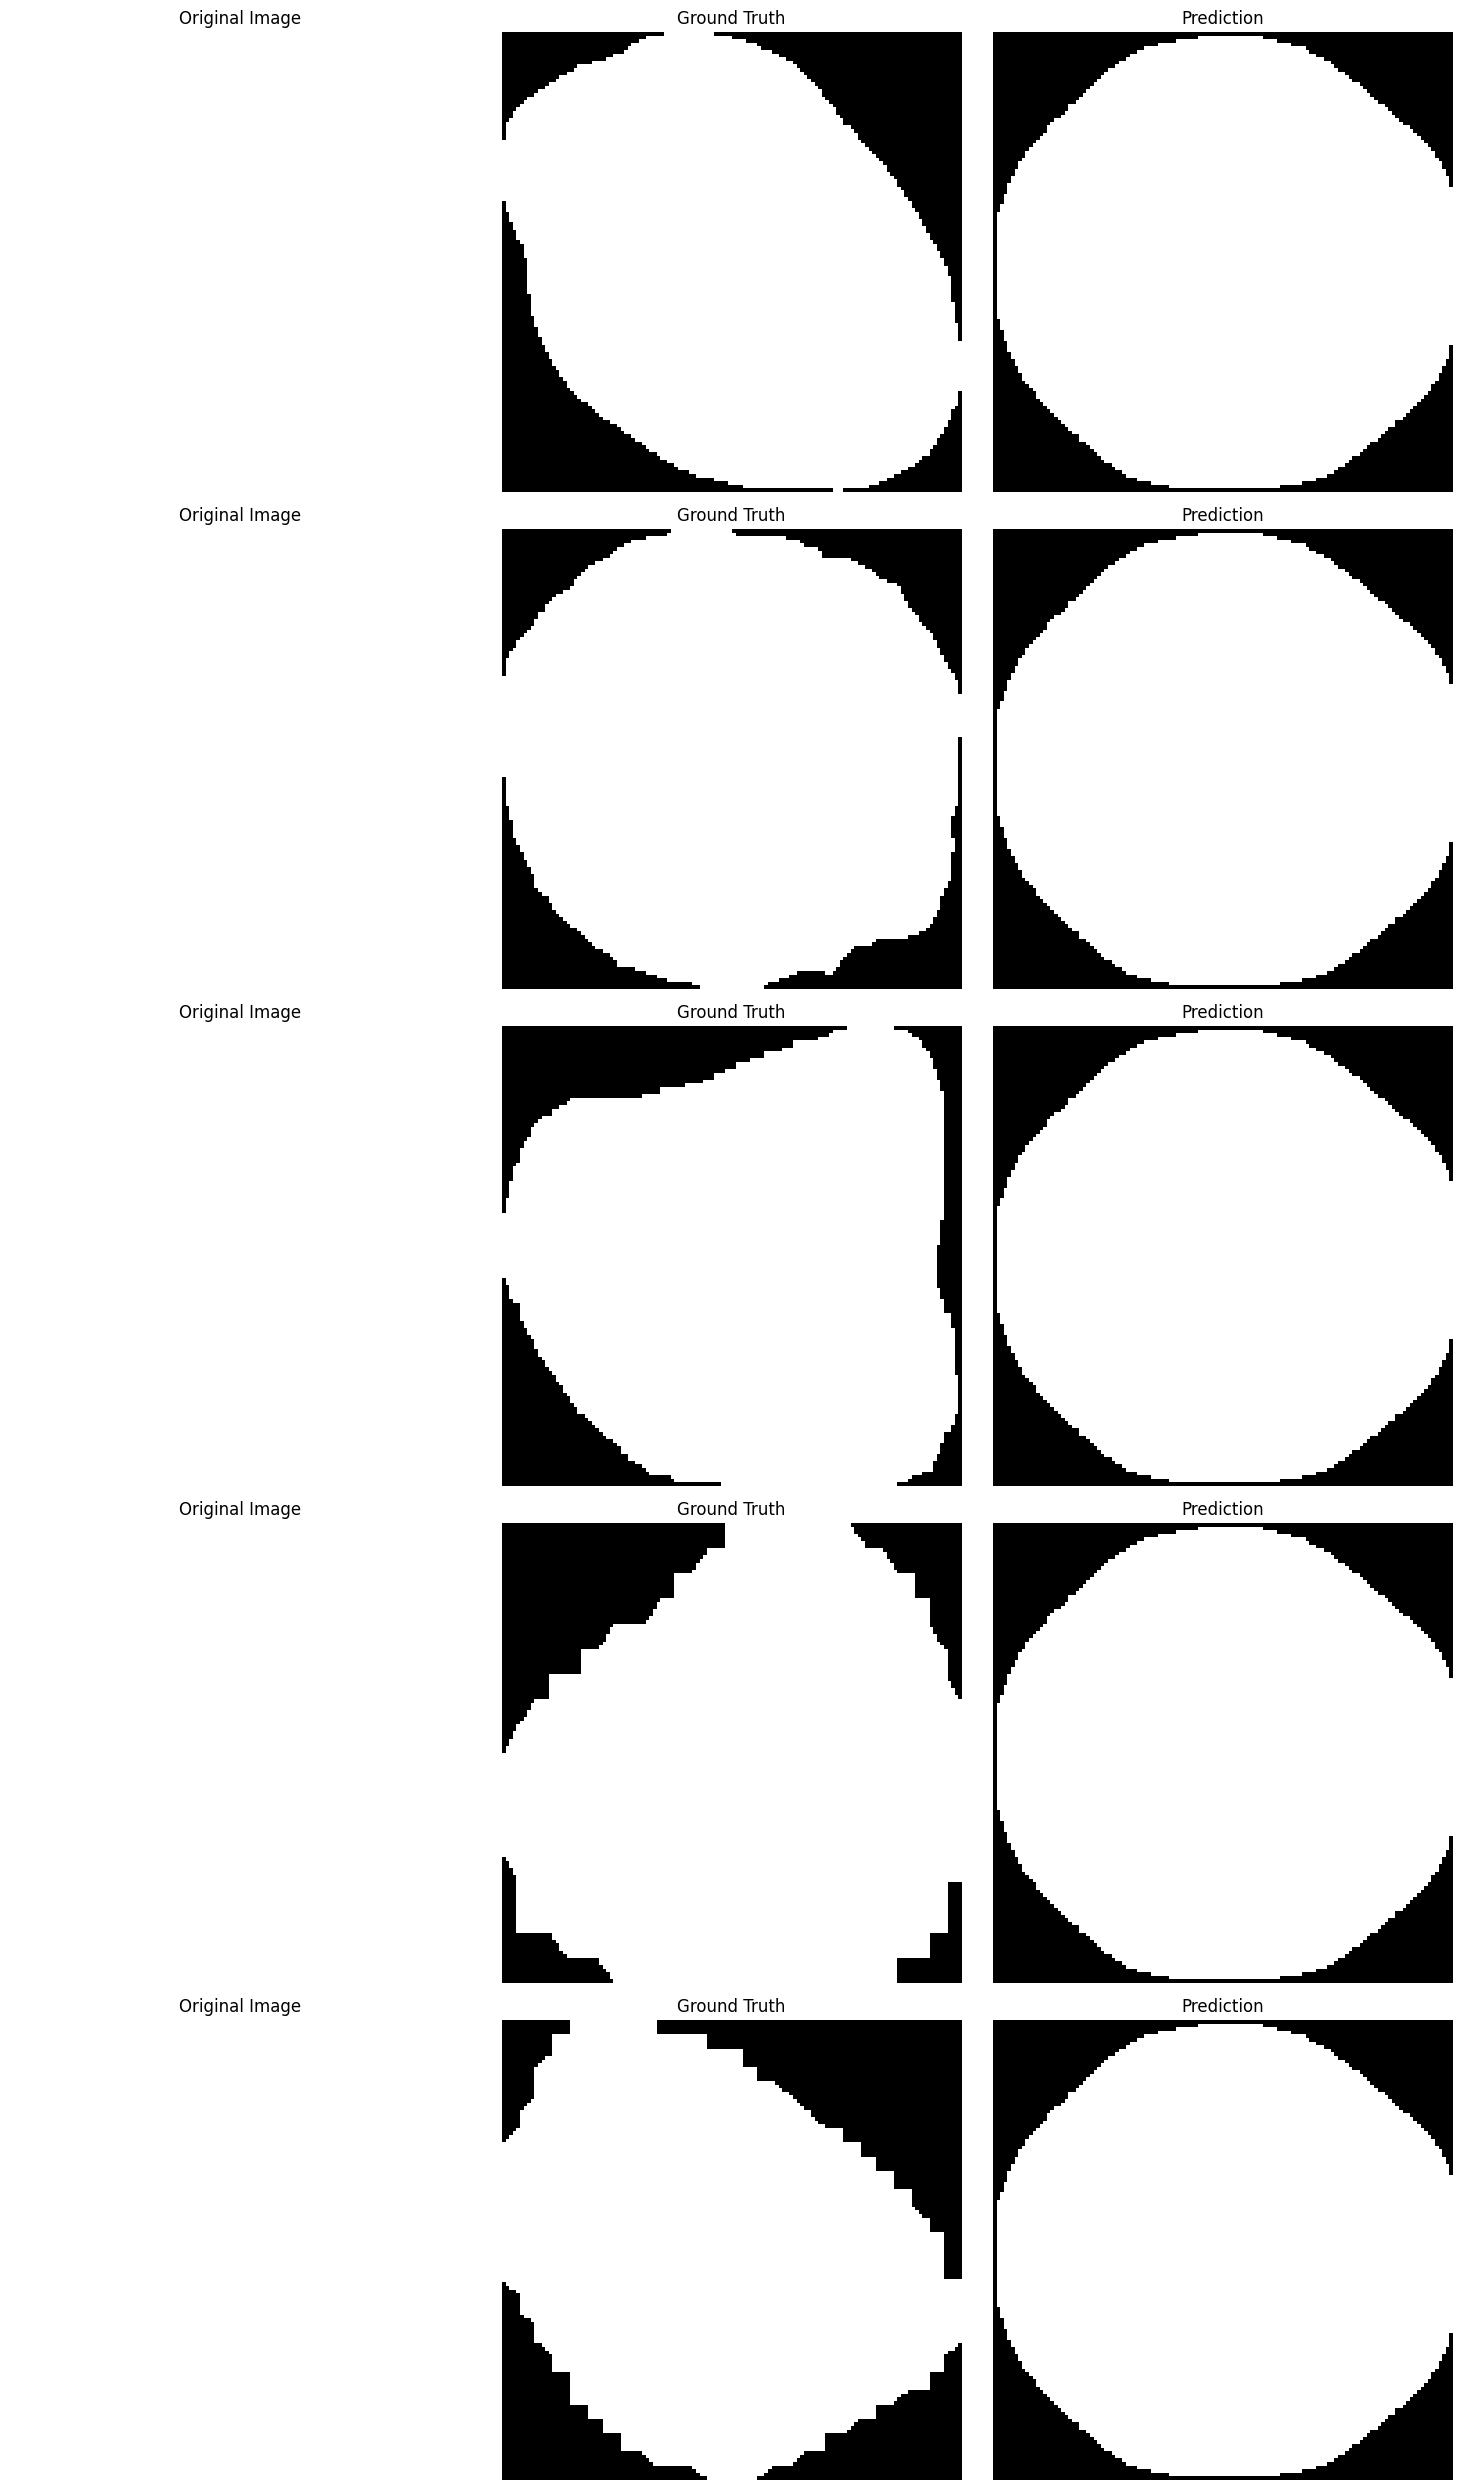

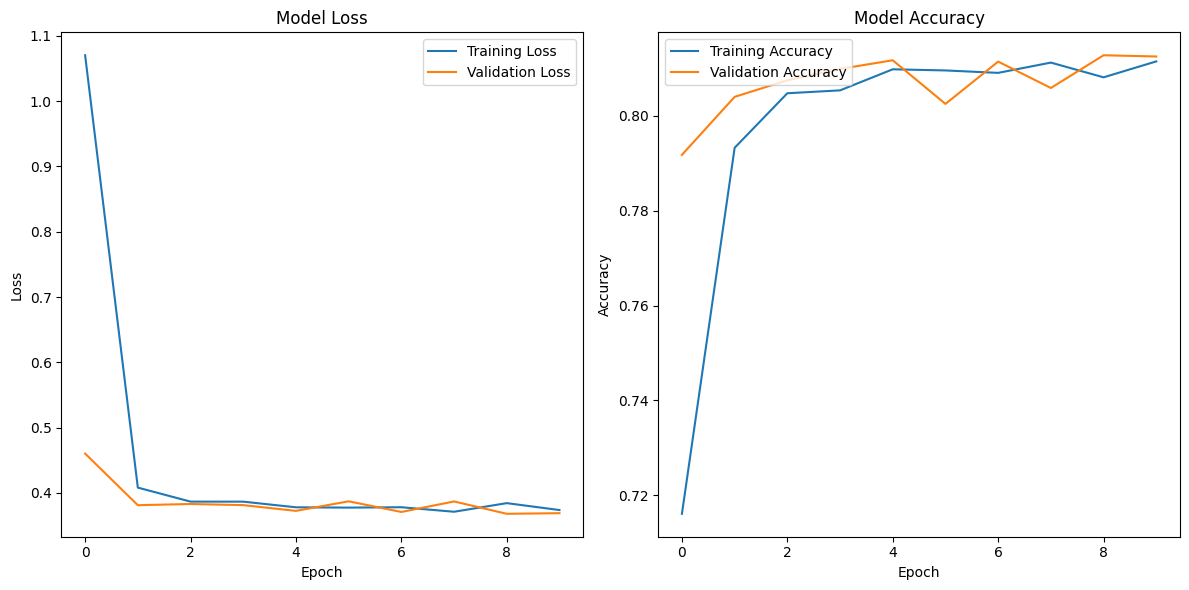

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths
base_path = '/home/ubuntu/BTS/Breast_Cancer_Segmentation/Mass_Data'
benign_path = os.path.join(base_path, 'Benign')
malignant_path = os.path.join(base_path, 'Malignant')

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Function to load images and masks
def load_data(img_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(img_folder):
        if filename.endswith(".png") and not "_MASK" in filename:
            img = load_img(os.path.join(img_folder, filename), target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img)  # No normalization here
            
            # Adjust the mask file name according to the actual naming pattern
            mask_name = filename.replace(".png", "_MASK.png")
            
            # Check if the mask file exists
            mask_path = os.path.join(mask_folder, mask_name)
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} not found for image {filename}")
                continue

            mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Normalize mask to [0, 1]
            images.append(img)
            masks.append(mask)
    
    images = np.array(images) / 255.0  # Normalize images to [0, 1] range
    return images, np.array(masks)

# Load Benign data
benign_images, benign_masks = load_data(benign_path, benign_path)

# Load Malignant data
malignant_images, malignant_masks = load_data(malignant_path, malignant_path)

# Combine data
images = np.concatenate((benign_images, malignant_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks), axis=0)

# Split the data into training, validation, and testing sets
X_train, X_temp, Y_train, Y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Data augmentation
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Create augmented data generators
train_image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
train_mask_generator = mask_datagen.flow(Y_train, batch_size=32, seed=42)
val_image_generator = image_datagen.flow(X_val, batch_size=32, seed=42)
val_mask_generator = mask_datagen.flow(Y_val, batch_size=32, seed=42)

# Combine generators into one which yields image and mask
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

# Build U-Net Model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # Contracting path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)
    
    # Expanding path
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
model = unet_model()

# Train the model with augmented data and validation set
history = model.fit(train_generator, 
                    steps_per_epoch=len(X_train) // 32, 
                    epochs=10, 
                    validation_data=val_generator, 
                    validation_steps=len(X_val) // 32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save('path_to_save_model/my_unet_model')

# Visualize predictions on the test set
def plot_predictions(model, X_test, Y_test, num=5, threshold=0.5):
    predictions = model.predict(X_test[:num])
    plt.figure(figsize=(15, num * 5))
    
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        
        # Normalize if necessary
        if X_test[i].max() > 1:
            X_test[i] = X_test[i] / 255.0
        
        if X_test[i].shape[-1] == 3:  # RGB Image
            plt.imshow(X_test[i])
        else:
            plt.imshow(X_test[i].squeeze(), cmap='gray')
        
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(Y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(num, 3, i*3 + 3)
        predicted_mask = (predictions[i].squeeze() > threshold).astype(np.uint8)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(model, X_test, Y_test)

# Plot training history
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Visualize the history
plot_history(history)
